# Introduction
Before we get into the several strategies for aspect-level sentiment analysis, we must first define an aspect. Aspects are a set of semantically rich, concept-centric terms that signify specific features or characteristics of the review or comment. For example, If we consider Example shown below Location, and food are all aspects to consider.

Aspect-based sentiment analysis (ABSA) is a text analysis technique that categorizes data by aspect and identifies the sentiment attributed to each one. We will use it to analyze customer feedback for flipkart products by associating specific sentiments with different aspects of a product or service.

Aspect Based Sentiment Analysis can be categorized into two types :-

Supervised ABSA :- In Supervised approach we provide the seed words which than help supervised model to extract aspects of the sentence. If it identifies the particular aspects for that seed then it tags those sentences with those aspects.

Unsupervised ABSA :- As it is obvious providing the seed for each sentence is a difficult task plus let say if our dataset is large (20-100k) than that will become a nightmare. Topic Modeling is the technique which helps extract latent topics from a document, in our case we will extract aspect from a sentence using topic modeling techniques such as latent Dirichlet algorithm (LDA).

Aspect Based Sentiment Analysis is a Natural Language Processing (NLP) Based Approach so we will deal it like that and follow the below mentioned pipeline for a NLP task.

In [90]:
import pandas as pd
import torch
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# About Flipkart Movile Review Dataset

Before Loading the dataset I want to specify few details about data. The data is fetched from flipkart India web page contains 83 tables in which 1 table contains information about rest 82 tables. Those rest 82 tables contains reviews of 82 mobile phones.

A table which contains information about mobile phones has following attributes.

- product_id
- product_name
- price
- category
- sub_category
- specifications
- ratings
- discount
- moreinfo

Tables containing reviews of 82 mobile phones has following attributes.

- product_id
- review_id
- title
- review
- likes
- dislikes
- ratings
- reviewer

In [92]:
import sqlite3

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("/content/drive/MyDrive/Major_project/flipkart_products.db")
items = pd.read_sql_query("SELECT * from items", con)
con.close()

In [93]:
items.head()

,product_id,product_name,price,category,sub_category,specifications,ratings,discount,moreinfo
0,ECMB000001,"Redmi 9A (SeaBlue, 32 GB)","₹7,413",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-seablue-32-gb/p/itmeabd39a0cd669?pid...
1,ECMB000002,"Redmi 9A (Midnight Black, 32 GB)","₹7,421",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-midnight-black-32-gb/p/itmeabd39a0cd...
2,ECMB000003,"Redmi 9A (Nature Green, 32 GB)","₹7,384",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,4.0,/redmi-9a-nature-green-32-gb/p/itmeabd39a0cd66...
3,ECMB000004,"Redmi 9 (Carbon Black, 64 GB)","₹10,745",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-carbon-black-64-gb/p/itm4fb151383983b...
4,ECMB000005,"Redmi 9 (Sky Blue, 64 GB)","₹10,489",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-sky-blue-64-gb/p/itm4fb151383983b?pid...


In [94]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_id      82 non-null     object
 1   product_name    82 non-null     object
 2   price           82 non-null     object
 3   category        82 non-null     object
 4   sub_category    82 non-null     object
 5   specifications  82 non-null     object
 6   ratings         82 non-null     object
 7   discount        34 non-null     object
 8   moreinfo        82 non-null     object
dtypes: object(9)
memory usage: 5.9+ KB


In [95]:
con = sqlite3.connect("/content/drive/MyDrive/Major_project/flipkart_products.db")

df = pd.read_sql_query("SELECT * from ECMB000001", con)

for i in range(2, len(items) + 1):

    df_temp = pd.read_sql_query("SELECT * from ECMB{:06d}".format(i), con)
    df = pd.concat([df, df_temp])
con.close()

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53493 entries, 0 to 289
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  53493 non-null  object
 1   review_id   53493 non-null  object
 2   title       53493 non-null  object
 3   review      53493 non-null  object
 4   likes       53493 non-null  object
 5   dislikes    53493 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    53493 non-null  object
dtypes: object(8)
memory usage: 3.7+ MB


In [97]:
df.head()

,product_id,review_id,title,review,likes,dislikes,ratings,reviewer
0,ECMB000001,ECMB0000010000001,Excellent,Wow superb I love it❤️👍 battery backup so nice 👍👍,740,160,5,Abhishek Saini
1,ECMB000001,ECMB0000010000002,Worth the money,Mobile So Good In Range Redmi 9a Has Miui 12 L...,355,104,4,Dinesh Kumar Sahni
2,ECMB000001,ECMB0000010000003,Just wow!,Wonderful device and smart phone best camera b...,125,47,5,Flipkart Customer
3,ECMB000001,ECMB0000010000004,Simply awesome,Very good mobile. Value for money. Battery bac...,0,0,5,Amit Sen
4,ECMB000001,ECMB0000010000005,Highly recommended,Really great.... value for money...,90,15,5,Sudeshna pakira


# Managing Missing Data

Missing data are not rare in real data sets. In fact, the chance that at least one data point is missing increases as the data set size increases. Missing data can occur any number of ways, some of which include the following.

- Merging of source data sets
- Random events
- Failures of measurement

<Figure size 2500x2000 with 0 Axes>

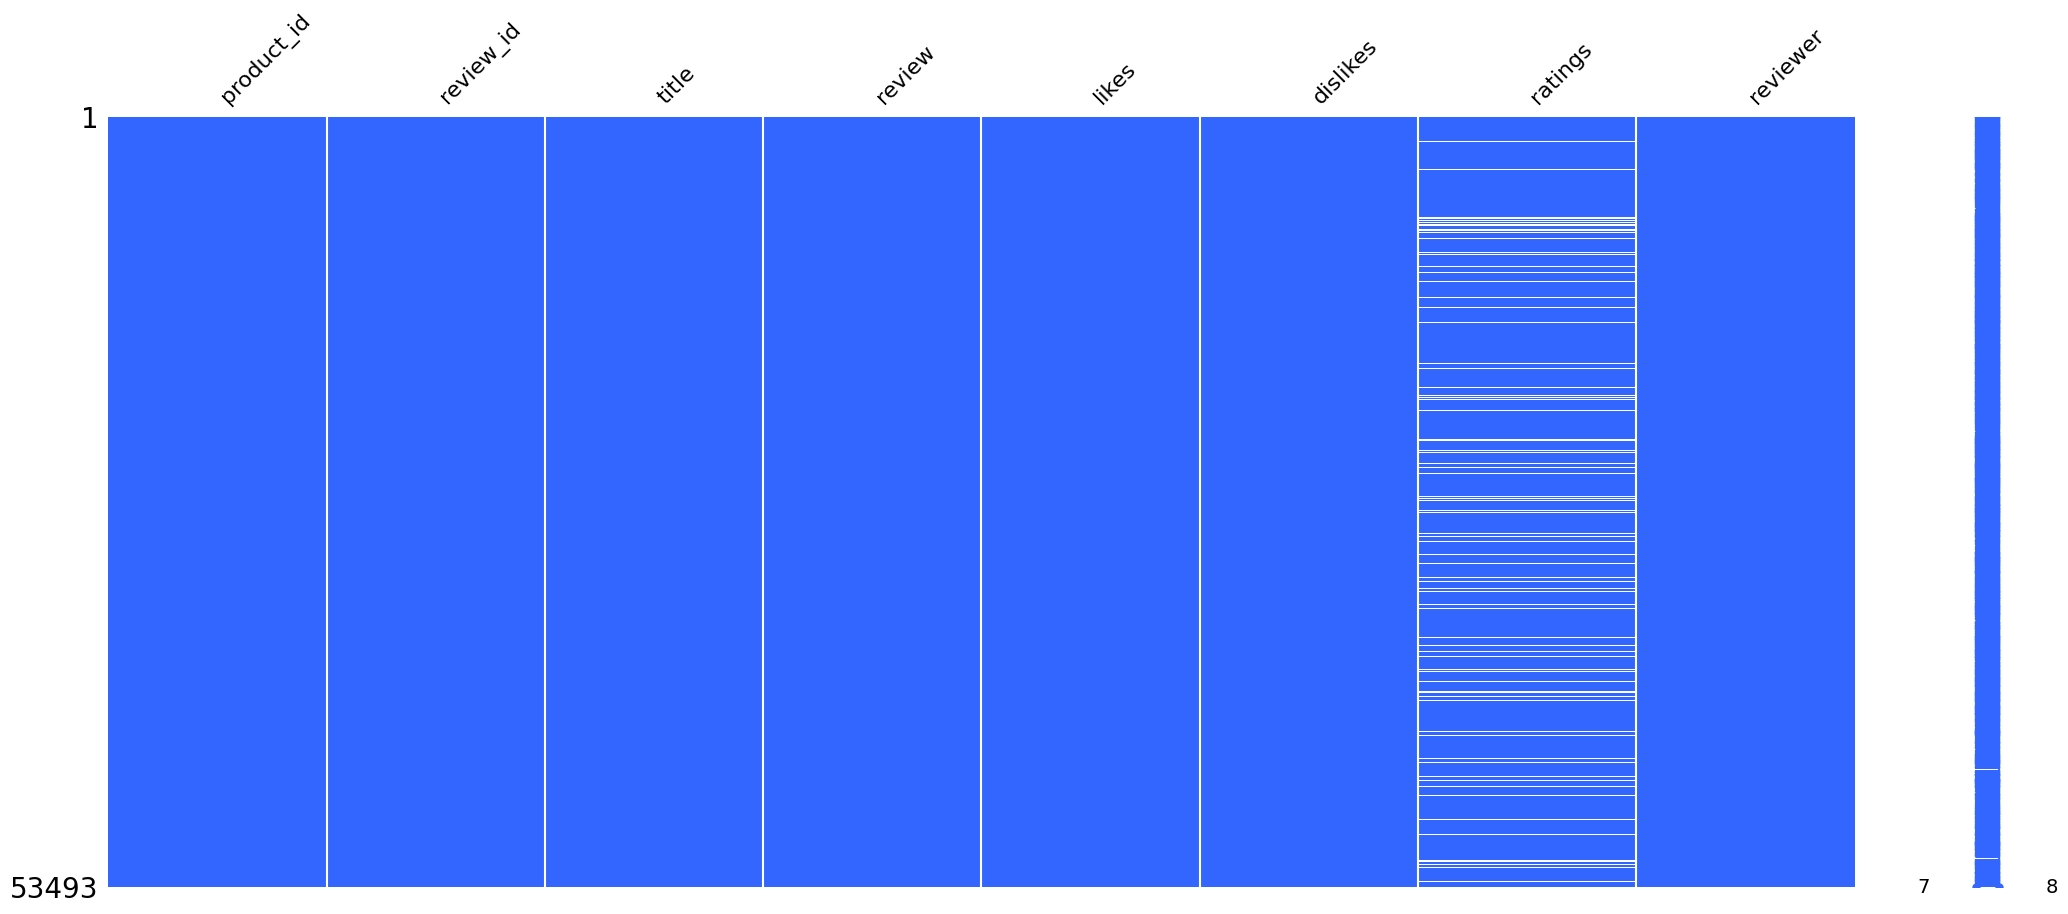

In [98]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

We can handle missing values using lots of techniques like simple statistical methods, using machine learning models and many more but in this case majority of missing values are from ratings column and we will use that column as label column later so I don't want to fake out or ruin the original distribution of the label data specially so thats why I will be dropping the rows having missing values in column ratings. Dropping technique in never recommended but in this senario I am using it.

In [99]:
df.dropna(inplace=True, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48488 entries, 0 to 287
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  48488 non-null  object
 1   review_id   48488 non-null  object
 2   title       48488 non-null  object
 3   review      48488 non-null  object
 4   likes       48488 non-null  object
 5   dislikes    48488 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    48488 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


<Figure size 2500x2000 with 0 Axes>

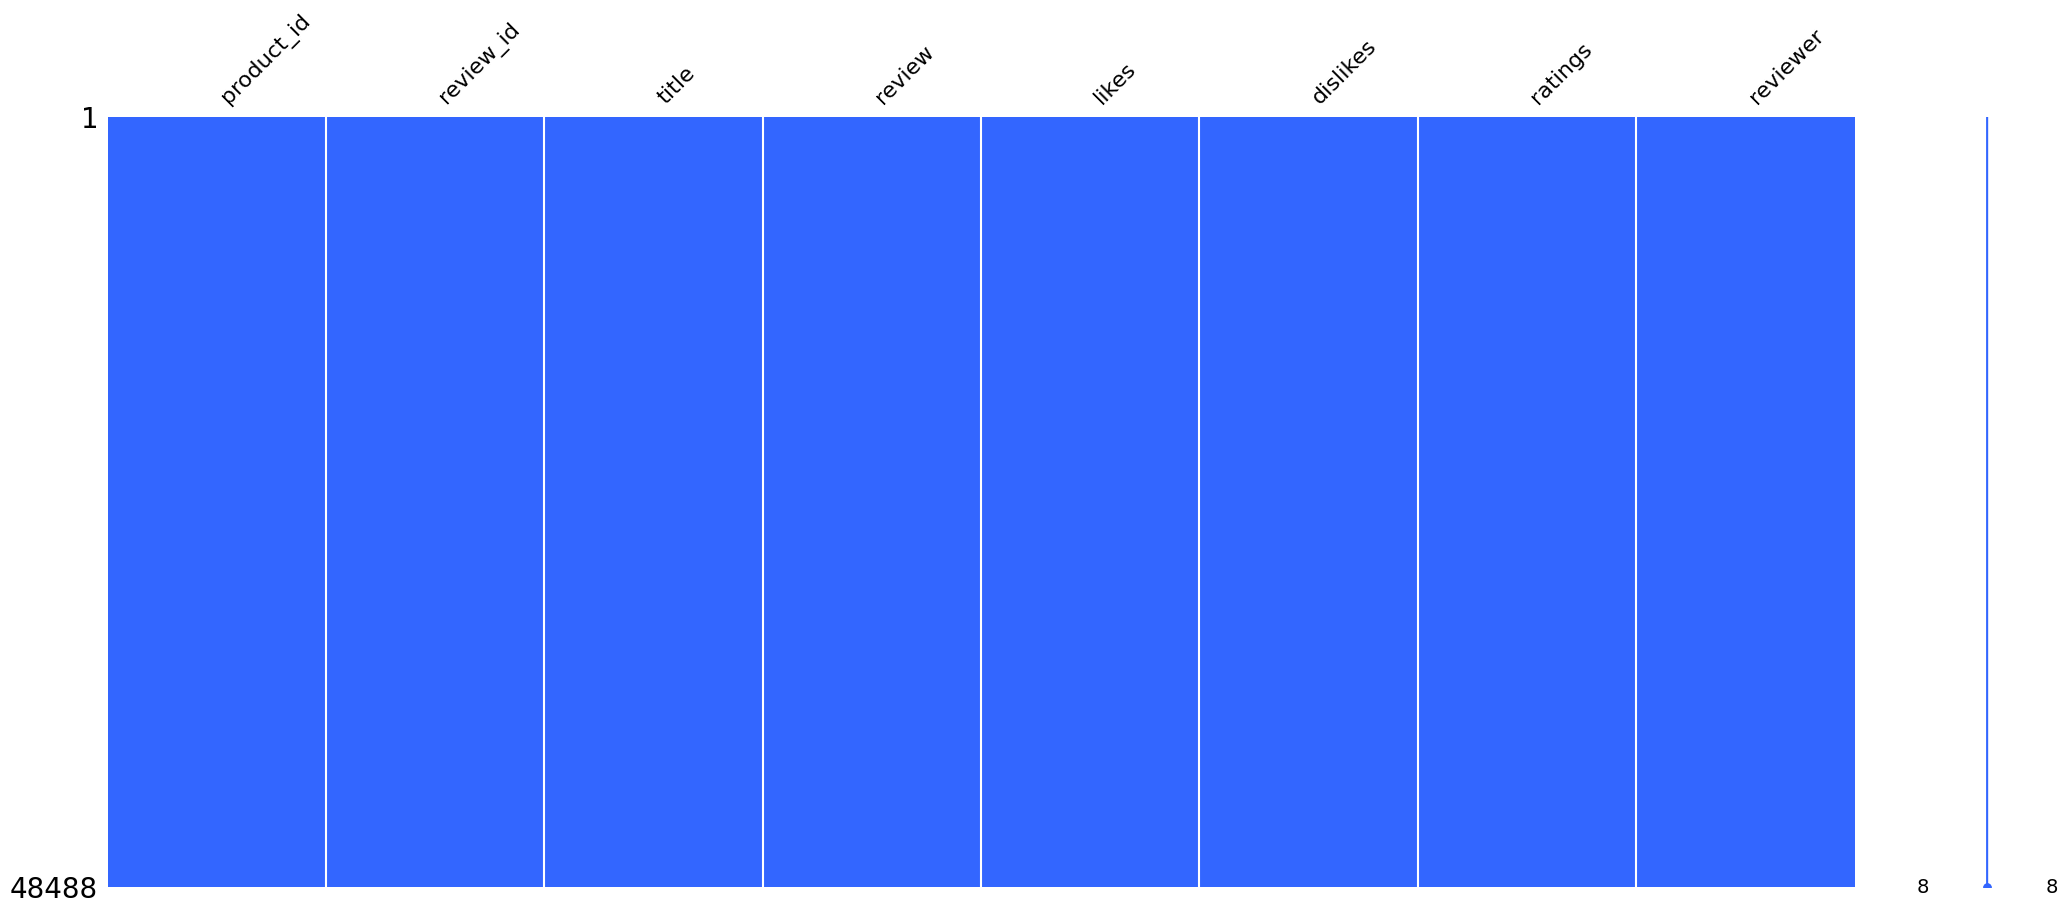

In [100]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

# Text Cleaning
 Text Cleaning is the process of extracting raw text from input data and converting it to the required encoding format by removing all non-textual material like markups and metadata. This is usually determined by the data format of the organisation (e.g., static data from PDF, HTML).

Text cleaning is an important step in any NLP effort. And it may consume the majority of your project's time. We will discuss following techniques in upcoming subsections of text cleaning.

- HTML Parsing and Cleanup
- Unicode Normalization
- Spelling Correction

In [101]:
import re


def remove_url(text):
    text = re.sub(r"http\S+", "", text)
    return text


# Example string with weird font characters plus an URL which we gonna remove.
sample = "Heyyo My name is Anshumali Karna 😻 \n https://www.kaggle.com/anshumalikarna An I Love you all 😊"
print(f"Text before removing url:- \n {sample}")

sample = remove_url(sample)
print(f"Text after removing url:- \n {sample}")

Text before removing url:- 
 Heyyo My name is Anshumali Karna 😻 
 https://www.kaggle.com/anshumalikarna An I Love you all 😊
Text after removing url:- 
 Heyyo My name is Anshumali Karna 😻 
  An I Love you all 😊


In [102]:
print("\u00C7", "\u0043\u0327")

Ç Ç


In [103]:
"\u00C7" == "\u0043\u0327"

False

In [104]:
"Ç" == "Ç"

False

In [105]:
import unicodedata as uni

print(f"Text before Unicode Normalization:- \n {sample}")

sample = uni.normalize('NFKD', sample)
print(f"Text after Unicode Normalization:- \n {sample}")

Text before Unicode Normalization:- 
 Heyyo My name is Anshumali Karna 😻 
  An I Love you all 😊
Text after Unicode Normalization:- 
 Heyyo My name is Anshumali Karna 😻 
  An I Love you all 😊


In [106]:
!pip install demoji

# Handling Emojis 🫣

We need to handle emojis because they store lots of important information about the sentiment of the text we dont't want to lose this information by just removing them from the text. There are lots of ways to handle them in this notebook I am replacing them with their English version using python library "demoji".

What is an Emoji 🤔?

Emojis are small digital images or icons that are used to convey a message or emotion. These are small enough to be inserted into a text document. "e" stands for image, while "moji" stands for character in Japanese.

Consider the example of Emoji Handling

I ❤ 🍔 so much

English version of above comment is

I love burger so much

What is an Emoticon ‘ :-) ’?

An emoticon is a combination of the words "emotion" and "icon." It is a keyboard depiction of a facial expression, such as a smile or frown, that is used to indicate the writer's feelings or intended tone.

Examples- :-) Smile

;-) Smile with a wink

In [107]:
import demoji


def handle_emoji(string):
    emojis = demoji.findall(string)

    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string


print(f"Before Handling emoji:- \n {sample}")
print(f"After Handling emoji:- \n {handle_emoji(sample)}")

Before Handling emoji:- 
 Heyyo My name is Anshumali Karna 😻 
  An I Love you all 😊
After Handling emoji:- 
 Heyyo My name is Anshumali Karna  smiling cat with heart-eyes 
  An I Love you all  smiling face with smiling eyes


# Text Preprocessing

In the previous section we covered the text extraction and cleaning phase of a NLP project. Question may arise if we did the cleaning and extraction task then why do we need text-preprocessing phase. Answer is pretty simple any NLP project consist of modelling phase in which we train the model so that we can use it for real world data. And model needs numerical data but our data is textual so that's why we have to do various text preprocessing task.

Below I mentioned few pre-processing tasks:-

- Preliminaries
  - Sentence segmentation and word tokenization.
- Frequent steps
  - Stop word removal, stemming and lemmatization, removing digits/punctuation, lowercasing, etc.
- Other steps
  - Normalization, language detection, code mixing, transliteration, etc.
- Advanced processing
  - POS tagging, parsing, coreference resolution, etc.
above mentioned task vary according to the task or model we wil use.

In [108]:
def word_tokenizer(text):
    text = text.lower()
    text = text.split()

    return text


sample = "Hi Everyone I am Anshumali."
print(sample)
print(word_tokenizer(sample))

Hi Everyone I am Anshumali.
['hi', 'everyone', 'i', 'am', 'anshumali.']


In [109]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [110]:
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english'))
print(f"Stop Words in English : \n{ en_stopwords}")

Stop Words in English : 
{'then', 'll', "you'd", "haven't", 'mustn', 'isn', "won't", 'o', 'who', 'just', 'why', 'through', 'your', 'now', 'on', 'than', 'an', 'with', "don't", 'what', 'out', 'd', 'have', 'where', 'herself', 'other', 'me', 'and', 'of', 'theirs', 'until', 'himself', 'any', 'below', "aren't", 'did', 'at', "shan't", 'shouldn', 'same', 'been', 'when', 'ours', 'them', 've', 'him', 'further', 'very', 'down', 'weren', 'nor', 'some', 'themselves', 'no', 's', 'm', 'she', "wouldn't", 'few', "needn't", 'doing', 'shan', "shouldn't", 'does', 'a', 'in', 'there', "didn't", 't', 'such', "you're", 're', 'this', 'over', 'these', 'yourselves', 'up', "hasn't", 'which', 'own', "should've", 'by', 'y', 'for', 'off', 'it', 'is', 'to', 'so', 'be', 'only', "couldn't", 'because', 'that', 'those', 'above', 'but', 'most', 'wouldn', "wasn't", 'while', 'ma', 'his', 'had', "you'll", 'whom', 'were', 'ain', 'has', "she's", 'will', "isn't", 'doesn', 'hadn', 'about', 'after', 'into', "mightn't", "you've", 

In [111]:
def remove_stopwords(text):
    text = [word for word in text if word not in en_stopwords]
    return text


print(f"Before removing stopwords : {word_tokenizer(sample)}")
print(f"After removing stopwords : {remove_stopwords(word_tokenizer(sample))}")

Before removing stopwords : ['hi', 'everyone', 'i', 'am', 'anshumali.']
After removing stopwords : ['hi', 'everyone', 'anshumali.']


In [112]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

stemmer = PorterStemmer()
# stemmer = LancasterStemmer()


def stemming(text):

    text = [stemmer.stem(word) for word in text]
    return text


sample = "I am creating a Notebook"
print(f"Before Stemming : {(sample)}")
print(f"After Stemming : {stemming(word_tokenizer(sample))}")

Before Stemming : I am creating a Notebook
After Stemming : ['i', 'am', 'creat', 'a', 'notebook']


In [113]:
import spacy

sp = spacy.load("en_core_web_sm")

In [114]:
def lemmatization(text):

    # text = [sp(word).lemma_ for word in text]

    text = " ".join(text)
    token = sp(text)

    text = [word.lemma_ for word in token]
    return text


print(f"Before Lemmatization : {word_tokenizer(sample)}")
print(f"After Lemmatization : {lemmatization(word_tokenizer(sample))}")

Before Lemmatization : ['i', 'am', 'creating', 'a', 'notebook']
After Lemmatization : ['I', 'be', 'create', 'a', 'notebook']


In [115]:
!pip install langdetect

In [116]:
from langdetect import detect


en_text = u""""Hi Everyone I am Anshumali Karna a Engineering Student"""
print(f" {en_text} : {detect(en_text)}")

hindi_text = u"""मेरा नाम अंशुमली कर्ण है और मैं एक अभियांत्रिक छात्र हूँ"""
print(f"{hindi_text} : {detect(hindi_text)}")

 "Hi Everyone I am Anshumali Karna a Engineering Student : tl
मेरा नाम अंशुमली कर्ण है और मैं एक अभियांत्रिक छात्र हूँ : hi


# Data Augmentation

We had the highly biased data. In this case, if we just output that the review is positive then also we will get 95% accuracy. But before the data augmentation approach, we feed this data to a bi-lstm-based model and we got 60-70% of accuracy which was not acceptable. So we did the Data augmentation and generate more negative reviews to balance the data and after that, we got 96-97% accuracy. In this section, I want to discuss what kind of data augmentation we use and what tool.

In [117]:
df_temp = df.copy()

In [118]:
def label(y):
    if y == '5':
        return 1
    elif y == '4':
        return 1
    else:
        return 0

from tqdm import tqdm

tqdm.pandas()

df_temp['y'] = df_temp.ratings.progress_map(label)

100%|██████████| 48488/48488 [00:00<00:00, 413165.77it/s]


In [119]:
df_temp = df_temp[['review', 'y', 'ratings']]

In [120]:
df_temp.head()

,review,y,ratings
0,Wow superb I love it❤️👍 battery backup so nice 👍👍,1,5
1,Mobile So Good In Range Redmi 9a Has Miui 12 L...,1,4
2,Wonderful device and smart phone best camera b...,1,5
3,Very good mobile. Value for money. Battery bac...,1,5
4,Really great.... value for money...,1,5


In [121]:
df_temp.y.value_counts()

1    44751
0     3737
Name: y, dtype: int64

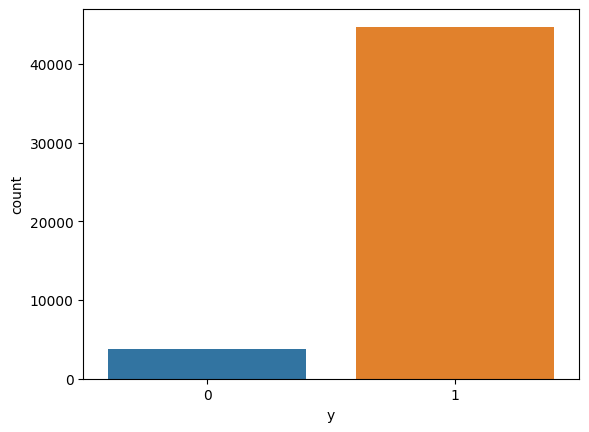

In [122]:
import seaborn as sns

sns.countplot(x = "y", data = df_temp)
plt.show()

In [123]:
df_temp2 = df_temp[(df_temp['ratings'] == '5')]

In [124]:
positive = list(df_temp2[(df_temp2['review'].str.len() > 100) & (df_temp2['review'].str.len() < 350)]['review'])
len(positive)

4803

In [125]:
!pip install nlpaug

In [126]:
import nlpaug.augmenter.word as naw

In [127]:
positive[41:49]

["An amazing smartphone for the price though i didn't like the colors compared to a realme phone in the same price range. It's a reall good second smartphone if you already have a primary device.",
 "Nice product according to its budget. But it's hard to play high Graphics games like pubg on 3GB RAM. It lags even when you play at Smooth Graphics settings. If this is for gaming (High graphics game) purpose, then don't go for 3GB or 2 GB RAM and the rest it works very well.",
 'I gave this phone to my wife as a gift and she loved it so much that she gets great performance and photos of games',
 'Every thing is great about the phone but a micro USB connector with a 5000 mah battery kind of suck a type c connector would have been better',
 'Very good handset at this price. Nice and great performance. Battery backup is also trustworthy. There is no issue till date after using for a period of 5days. Overall u can buy this phone without hesitation',
 'I am happy with your productus policy of 

In [128]:
aug = naw.AntonymAug(name='Antonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng', stopwords=en_stopwords, tokenizer=None,
                     reverse_tokenizer=None, stopwords_regex=None, verbose=0)

aug_negative = aug.augment(positive)

In [129]:
len(aug_negative)

4803

In [130]:
aug_negative[41:49]

["An amazing smartphone for the price though i didn ' t like the colors compared to a realme phone in the same price range. It ' s a reall evil second smartphone if you already have a secondary device.",
 "Nice product according to its budget. But it ' s hard to play low Graphics games like pubg on 3GB RAM. It lags even when you play at Smooth Graphics settings. If this is for gaming (Low graphics game) purpose, then don ' t stay in place for 3GB or 2 GB RAM and the rest it malfunction very disadvantageously.",
 'I take this phone to my wife as a gift and she hate it so little that she end great performance and photos of games',
 'Every thing is great about the phone but a micro USB connector with a 5000 mah battery kind of suck a type c connector would have been ill',
 'Very bad handset at this price. Nice and great performance. Battery backup is also untrustworthy. There is no issue till date after using for a period of 5days. Overall u can sell this phone without hesitation',
 'I am

In [131]:
df_negative = pd.DataFrame({"review" : aug_negative, 'y' : [0]*len(aug_negative)})

In [132]:
df_positive = pd.DataFrame({"review" : positive, 'y' : [1]*len(positive)})

In [133]:
df_temp = pd.concat([df_negative, df_positive]).sample(frac = 1, random_state = 11).reset_index(drop=True)

In [134]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9606 entries, 0 to 9605
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9606 non-null   object
 1   y       9606 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 150.2+ KB


In [135]:
df_temp.head()

,review,y
0,great phone in budget. .. pubg performance was...,0
1,Best Smartphone by Mi in this Range. . malfunc...,0
2,Bad smooth phone. . and back camera quality is...,0
3,Thise is very nice mobile ...I like it very mu...,1
4,I m meagerly dissatisfy 👍 All section r superb...,0


In [136]:
df = df_temp

In [137]:
def preprocessing(text):

    text = remove_url(text)
    text = uni.normalize('NFKD', text)
    text = handle_emoji(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = word_tokenizer(text)
    # text = stemming(text)
    text = lemmatization(text)
    text = remove_stopwords(text)
    text = " ".join(text)

    return text

In [138]:
from tqdm import tqdm

tqdm.pandas()

df['clean_review'] = df['review'].progress_map(preprocessing)

100%|██████████| 9606/9606 [01:55<00:00, 82.84it/s] 


In [139]:
df.head()

,review,y,clean_review
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...
1,Best Smartphone by Mi in this Range. . malfunc...,0,well smartphone mi range malfunction r confuse...
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...
4,I m meagerly dissatisfy 👍 All section r superb...,0,I meagerly dissatisfy thumb section r superb d...


In [140]:
reviews = df.clean_review.values.tolist()

In [141]:
from tqdm import tqdm

tqdm.pandas()

df['clean_review2'] = df['clean_review'].progress_map(word_tokenizer)

100%|██████████| 9606/9606 [00:00<00:00, 175752.18it/s]


In [142]:
df.head()

,review,y,clean_review,clean_review2
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug..."
1,Best Smartphone by Mi in this Range. . malfunc...,0,well smartphone mi range malfunction r confuse...,"[well, smartphone, mi, range, malfunction, r, ..."
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"[bad, smooth, phone, back, camera, quality, ba..."
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...,"[thise, nice, mobile, i, like, much, delivery,..."
4,I m meagerly dissatisfy 👍 All section r superb...,0,I meagerly dissatisfy thumb section r superb d...,"[i, meagerly, dissatisfy, thumb, section, r, s..."


# Latent Dirichlet Allocation (LDA)

### What does LDA do? Let’s start with a toy corpus.

Consider the following collection of documents, D1 to D5, and each document consists of a one sentence:

• D1: I like these mobile phones. • D2: Battery backup for this phone is great and camera quality is an add on feature. • D3: Look at the front camera I guess it is better than the rear camera. • D4: Processing Speed of this phone is great. • D5: I Like the battery most in this phone but I am not satisfied with the service of this company.

Learning a topic model on this collection using LDA may produce an output like this:

• Topic A: 30% battery, 15% camera, 10% Processor, 10% Service. • Topic B: 20% Rear Camera, 20% Front Camera, 20% Service, 20% Processor • Document 1 and 2: 100% Topic A • Document 3 and 4: 100% Topic B • Document 5: 60% Topic A, 40% Topic B

Topics are just a collection of keywords with a probability distribution, while documents are collections of topics with the same probability distribution. A topic model just provides a list of keywords for each topic. What is the situation?Human perception of what an issue symbolises and what it should be labelled is common in the context of an LDA model.

In [143]:
data_words = df['clean_review2'].values.tolist()
len(data_words)
print(data_words)

[['great', 'phone', 'budget', 'pubg', 'performance', 'rough', 'camera', 'worsen', 'worn', 'update', 'ni8', 'mode', 'cam', 'aadde', 'phone', 'also', 'evil', 'stupid', 'phone'], ['well', 'smartphone', 'mi', 'range', 'malfunction', 'r', 'confuse', 'samsung', 'm30', 'mi', 'note', '7', 'pro', 'mi', 'badly', 'look', 'price', 'range', 'also', 'samsung', 'evil', 'amoled', 'display', 'whis', 'attend', 'mi', 'phone', 'overall', 'bear'], ['bad', 'smooth', 'phone', 'back', 'camera', 'quality', 'bad', 'rear', 'camera', 'big', 'bit', 'high', 'value', 'money'], ['thise', 'nice', 'mobile', 'i', 'like', 'much', 'delivery', 'also', 'fast', 'lockdown', 'i', 'happy', 'thank', 'mi', 'redmi'], ['i', 'meagerly', 'dissatisfy', 'thumb', 'section', 'r', 'superb', 'delivery', 'guy', 'also', 'politeness', 'like', 'part', 'battery', 'backup', 'really', 'awesome', 'stop', 'tq', 'u', 'flipkart', 'two', 'heart', 'two', 'heart'], ['great', 'product', 'price', 'segmentit', 'deliver', 'well', 'performance', 'well', 'pic

In [144]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


In [145]:
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=id2word,
                     num_topics=num_topics, iterations=400)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"phone" + 0.025*"5" + 0.022*"i" + 0.020*"evil" + 0.018*"nasty" + '
  '0.017*"camera" + 0.016*"battery" + 0.013*"pubg" + 0.012*"like" + '
  '0.011*"price"'),
 (1,
  '0.100*"good" + 0.048*"phone" + 0.035*"camera" + 0.028*"battery" + '
  '0.019*"price" + 0.019*"quality" + 0.015*"performance" + 0.014*"look" + '
  '0.014*"mobile" + 0.013*"nice"'),
 (2,
  '0.068*"phone" + 0.041*"camera" + 0.029*"bad" + 0.026*"i" + 0.026*"evil" + '
  '0.019*"awesome" + 0.018*"price" + 0.017*"performance" + 0.016*"battery" + '
  '0.012*"quality"'),
 (3,
  '0.066*"i" + 0.033*"phone" + 0.024*"flipkart" + 0.022*"product" + '
  '0.020*"thank" + 0.016*"camera" + 0.016*"good" + 0.016*"mobile" + '
  '0.015*"redmi" + 0.015*"smile"'),
 (4,
  '0.043*"good" + 0.029*"phone" + 0.024*"mobile" + 0.020*"like" + '
  '0.016*"battery" + 0.016*"product" + 0.015*"camera" + 0.015*"i" + '
  '0.014*"price" + 0.012*"quality"'),
 (5,
  '0.045*"good" + 0.041*"i" + 0.033*"phone" + 0.024*"camera" + 0.024*"battery" '
  '+ 0.0

As we don't have labeled data so we need to make few assumptions regarding choosing of aspect from the comment. From above analysis using LDA we inerpret that below listed aspect are few important one which were mentioned in most of the comments.

- Phone
- Camera
- Battery
- Delivery
- Processor

We gonna create a similarity matrix now using python's gensim.

In [146]:
%%time
from gensim.models import FastText
fasttext_model = FastText(data_words, vector_size= 100, window=5, min_count=5, workers=4,sg=1)

CPU times: user 11.6 s, sys: 158 ms, total: 11.8 s
Wall time: 7.06 s


In [147]:
fasttext_model.save("/content/drive/MyDrive/Major_project/FastText-Model-For-ABSA.bin")

In [148]:
fasttext_model.wv.n_similarity("I really like the camera of this phone", "battery")

0.93842554

In [149]:
fasttext_model.wv.n_similarity("I really like the camera of this phone", "camera")

0.88663095

In [151]:
aspects = ["phone", "camera", "battery", "delivery", "processor"]

def get_similarity(text, aspect):
    try:
        text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0

In [152]:
from tqdm import tqdm
tqdm.pandas()
for aspect in aspects:
    df[aspect] = df['clean_review2'].progress_map(lambda text: get_similarity(text, aspect))

100%|██████████| 9606/9606 [00:11<00:00, 833.11it/s] 


In [153]:
df.head()

,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug...",0.909301,0.873522,0.939488,0.914758,0.890849
1,Best Smartphone by Mi in this Range. . malfunc...,0,well smartphone mi range malfunction r confuse...,"[well, smartphone, mi, range, malfunction, r, ...",0.909982,0.826995,0.927129,0.938727,0.851776
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"[bad, smooth, phone, back, camera, quality, ba...",0.867018,0.899203,0.937809,0.917161,0.908380
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...,"[thise, nice, mobile, i, like, much, delivery,...",0.871650,0.840858,0.902955,0.953723,0.844741
4,I m meagerly dissatisfy 👍 All section r superb...,0,I meagerly dissatisfy thumb section r superb d...,"[i, meagerly, dissatisfy, thumb, section, r, s...",0.839214,0.860965,0.960258,0.966276,0.890062


In [154]:
df.to_csv("/content/drive/MyDrive/Major_project/Clean_Flipkart_Product.csv", index = False)

In [155]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import warnings

In [156]:
class config:
    warnings.filterwarnings("ignore", category = UserWarning)
    IMG_SIZE = (224,224)
    DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
    FOLDS = 5
    SHUFFLE = True
    BATCH_SIZE = 32
    LR = 0.01
    EPOCHS = 30
    EMB_DIM = 100
    MAX_LEN = 20
    MODEL_PATH = "/content/drive/MyDrive/Major_project/MyModelABSA.pt"

In [157]:
df = pd.read_csv("/content/drive/MyDrive/Major_project/Clean_Flipkart_Product.csv")
df.head()

,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"['great', 'phone', 'budget', 'pubg', 'performa...",0.909300,0.873522,0.939488,0.914758,0.890849
1,Best Smartphone by Mi in this Range. . malfunc...,0,well smartphone mi range malfunction r confuse...,"['well', 'smartphone', 'mi', 'range', 'malfunc...",0.909982,0.826995,0.927129,0.938727,0.851776
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"['bad', 'smooth', 'phone', 'back', 'camera', '...",0.867018,0.899203,0.937809,0.917161,0.908380
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...,"['thise', 'nice', 'mobile', 'i', 'like', 'much...",0.871650,0.840858,0.902955,0.953723,0.844741
4,I m meagerly dissatisfy 👍 All section r superb...,0,I meagerly dissatisfy thumb section r superb d...,"['i', 'meagerly', 'dissatisfy', 'thumb', 'sect...",0.839214,0.860965,0.960258,0.966276,0.890062


In [158]:
class Vocabulary:

    '''
    __init__ method is called by default as soon as an object of this class is initiated
    we use this method to initiate our vocab dictionaries
    '''
    def __init__(self, freq_threshold, max_size):
        '''
        freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
        max_size : max source vocab size. Eg. if set to 10,000, we pick the top 10,000 most frequent words and discard others
        '''
        #initiate the index to token dict
        ## <PAD> -> padding, used for padding the shorter sentences in a batch to match the length of longest sentence in the batch
        ## <SOS> -> start token, added in front of each sentence to signify the start of sentence
        ## <EOS> -> End of sentence token, added to the end of each sentence to signify the end of sentence
        ## <UNK> -> words which are not found in the vocab are replace by this token
        self.itos = {0: '<PAD>', 1:'<SOS>', 2:'<EOS>', 3: '<UNK>'}
        #initiate the token to index dict
        self.stoi = {k:j for j,k in self.itos.items()}

        self.freq_threshold = freq_threshold
        self.max_size = max_size

    '''
    __len__ is used by dataloader later to create batches
    '''
    def __len__(self):
        return len(self.itos)

    '''
    a simple tokenizer to split on space and converts the sentence to list of words
    '''
    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]

    '''
    build the vocab: create a dictionary mapping of index to string (itos) and string to index (stoi)
    output ex. for stoi -> {'the':5, 'a':6, 'an':7}
    '''
    def build_vocabulary(self, sentence_list):
        #calculate the frequencies of each word first to remove the words with freq < freq_threshold
        frequencies = {}  #init the freq dict
        idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk

        #calculate freq of words
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1


        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold}

        #limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk

        #create vocab
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx+=1


    '''
    convert the list of words to a list of corresponding indexes
    '''
    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = []
        for token in tokenized_text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.stoi['<UNK>'])

        return numericalized_text

In [159]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    '''
    Initiating Variables
    df: the training dataframe
    source_column : the name of source text column in the dataframe
    transform : If we want to add any augmentation
    freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
    source_vocab_max_size : max source vocab size
    '''

    def __init__(self, df, source_column,freq_threshold = 3,
                source_vocab_max_size = 10000 , transform=None):

        self.df = df
        self.transform = transform

        #get source and target texts
        self.source_texts = self.df[source_column]


        ##VOCAB class has been created above
        #Initialize source vocab object and build vocabulary
        self.source_vocab = Vocabulary(freq_threshold, source_vocab_max_size)
        self.source_vocab.build_vocabulary(self.source_texts.tolist())


    def __len__(self):
        return len(self.df)

    '''
    __getitem__ runs on 1 example at a time. Here, we get an example at index and return its numericalize source and
    target values using the vocabulary objects we created in __init__
    '''
    def __getitem__(self, index):
        source_text = self.source_texts[index]

        if self.transform is not None:
            source_text = self.transform(source_text)

        #numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.source_vocab.numericalize(source_text)
        numerialized_source.append(self.source_vocab.stoi["<EOS>"])

        #convert the list to tensor and return
        return torch.tensor(numerialized_source), torch.tensor(self.df.y[index])

In [160]:
df.head()

,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"['great', 'phone', 'budget', 'pubg', 'performa...",0.909300,0.873522,0.939488,0.914758,0.890849
1,Best Smartphone by Mi in this Range. . malfunc...,0,well smartphone mi range malfunction r confuse...,"['well', 'smartphone', 'mi', 'range', 'malfunc...",0.909982,0.826995,0.927129,0.938727,0.851776
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"['bad', 'smooth', 'phone', 'back', 'camera', '...",0.867018,0.899203,0.937809,0.917161,0.908380
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...,"['thise', 'nice', 'mobile', 'i', 'like', 'much...",0.871650,0.840858,0.902955,0.953723,0.844741
4,I m meagerly dissatisfy 👍 All section r superb...,0,I meagerly dissatisfy thumb section r superb d...,"['i', 'meagerly', 'dissatisfy', 'thumb', 'sect...",0.839214,0.860965,0.960258,0.966276,0.890062


In [161]:
dataset = CustomDataset(df, "clean_review")

In [162]:
len(dataset.source_vocab.stoi)

3304

In [163]:
import pickle

with open('/content/drive/MyDrive/Major_project/dataset-new', 'wb') as dataset_file:

  # Step 3
    pickle.dump(dataset, dataset_file, pickle.HIGHEST_PROTOCOL)

In [164]:
def get_emb_layer_with_weights(target_vocab, emb_model, trainable = False):

    weights_matrix = np.zeros((len(target_vocab), config.EMB_DIM))
    words_found = 0

    for i, word in enumerate(target_vocab):
        weights_matrix[i] = np.concatenate([emb_model.wv[word]])
        words_found += 1

    print(f"Words found are : {words_found}")

    weights_matrix = torch.tensor(weights_matrix, dtype = torch.float32).reshape(len(target_vocab), config.EMB_DIM)
    emb_layer = nn.Embedding.from_pretrained(weights_matrix)
    print(emb_layer)
    if trainable:
        emb_layer.weight.requires_grad = True
    else:
        emb_layer.weight.requires_grad = False

    return emb_layer

In [165]:
class MyCollate:
    def __init__(self, pad_idx, maxlen):
        self.pad_idx = pad_idx
        self.maxlen = maxlen


    #__call__: a default method
    ##   First the obj is created using MyCollate(pad_idx) in data loader
    ##   Then if obj(batch) is called -> __call__ runs by default
    def __call__(self, batch):
        #get all source indexed sentences of the batch
        source = [item[0] for item in batch]
        #pad them using pad_sequence method from pytorch.
#         source = pad_sequence(source, batch_first=False, padding_value = self.pad_idx)

        padded_sequence = torch.zeros((self.maxlen, len(batch)), dtype = torch.int)

        for idx, text in enumerate(source):

            if len(text) > self.maxlen:
                padded_sequence[:, idx] = source[idx][: self.maxlen]
            else:
                padded_sequence[:len(source[idx]), idx] = padded_sequence[:len(source[idx]), idx] + source[idx]


        #get all target indexed sentences of the batch
        target = [item[1] for item in batch]

        target = torch.tensor(target, dtype = torch.float32).reshape(-1)
        return padded_sequence, target

# Model


<img src="download-2.jpg" style="width: 700px; height: 500px"/>

In [166]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_layer):
        super().__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.hidden_dim = hidden_dim
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()



    def forward(self, text):

        max_len, N = text.shape
        hidden = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        memory = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        hidden = hidden.to(config.DEVICE)
        memory = memory.to(config.DEVICE)
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded, (hidden, memory))
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        y_pred = output[-1,:,:]
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        y_pred = self.sigmoid(y_pred)

        return y_pred

In [167]:
def train_epochs(dataloader,model, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0

    model.train()

    for review, label in tqdm(dataloader):

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        optimizer.zero_grad()
        output = model(review)
        output = output.reshape(-1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        train_correct += (prediction == label).float().sum()

    return train_loss, train_correct

In [168]:
def val_epochs(dataloader, model, loss_fn):
    val_correct = 0
    val_loss = 0

    model.eval()
#     hidden = model.init_hidden(config.BATCH_SIZE)

    for review, label in dataloader:

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)

        output = model(review)
        output = output.reshape(-1)

        loss = loss_fn(output, label)

        val_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        val_correct += (prediction == label).float().sum()
#         prediction =
    return val_loss, val_correct

In [169]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------0-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:02<00:00, 99.69it/s] 


| Train Loss : 0.6925543737808656 |  Val Loss : 0.6919472389985322 | Train Acc : 51.31441879272461 | Val Acc : 49.0634765625 |


100%|██████████| 241/241 [00:01<00:00, 161.57it/s]


| Train Loss : 0.6891799808355249 |  Val Loss : 0.6845899745899482 | Train Acc : 54.69807434082031 | Val Acc : 62.1227912902832 |


100%|██████████| 241/241 [00:01<00:00, 158.96it/s]


| Train Loss : 0.6758514043255934 |  Val Loss : 0.6615252505976253 | Train Acc : 60.61947250366211 | Val Acc : 51.35275650024414 |


100%|██████████| 241/241 [00:01<00:00, 181.25it/s]


| Train Loss : 0.5009687086494561 |  Val Loss : 0.6759100317195228 | Train Acc : 77.52472686767578 | Val Acc : 73.93340301513672 |


100%|██████████| 241/241 [00:01<00:00, 207.11it/s]


| Train Loss : 0.3004163104511375 |  Val Loss : 0.15626173679262367 | Train Acc : 88.13117980957031 | Val Acc : 94.48491668701172 |


100%|██████████| 241/241 [00:01<00:00, 203.25it/s]


| Train Loss : 0.23758374456217332 |  Val Loss : 0.2464048589553595 | Train Acc : 90.8250961303711 | Val Acc : 89.64620971679688 |


100%|██████████| 241/241 [00:01<00:00, 202.14it/s]


| Train Loss : 0.20691078173686042 |  Val Loss : 0.138094458616611 | Train Acc : 91.81416320800781 | Val Acc : 95.21332550048828 |


100%|██████████| 241/241 [00:01<00:00, 206.78it/s]


| Train Loss : 0.18430949773548297 |  Val Loss : 0.13793496041714712 | Train Acc : 92.68610382080078 | Val Acc : 94.74506378173828 |


100%|██████████| 241/241 [00:01<00:00, 208.48it/s]


| Train Loss : 0.18471785422990497 |  Val Loss : 0.2178124688269181 | Train Acc : 92.66007232666016 | Val Acc : 91.46722412109375 |


100%|██████████| 241/241 [00:01<00:00, 205.86it/s]


| Train Loss : 0.17895278268634793 |  Val Loss : 0.1257620870245235 | Train Acc : 93.02446746826172 | Val Acc : 95.21332550048828 |


100%|██████████| 241/241 [00:01<00:00, 174.20it/s]


| Train Loss : 0.17020389655646653 |  Val Loss : 0.1278437888414505 | Train Acc : 93.45393371582031 | Val Acc : 95.00521087646484 |


100%|██████████| 241/241 [00:01<00:00, 156.96it/s]


| Train Loss : 0.16435473119449268 |  Val Loss : 0.14109270259908532 | Train Acc : 93.61009979248047 | Val Acc : 95.21332550048828 |


100%|██████████| 241/241 [00:01<00:00, 174.49it/s]


| Train Loss : 0.1620164907952884 |  Val Loss : 0.14742094096916647 | Train Acc : 93.61009979248047 | Val Acc : 95.10926818847656 |


100%|██████████| 241/241 [00:01<00:00, 205.10it/s]


| Train Loss : 0.1612153413692438 |  Val Loss : 0.12282822366210784 | Train Acc : 93.74024200439453 | Val Acc : 95.57752990722656 |


100%|██████████| 241/241 [00:01<00:00, 207.24it/s]


| Train Loss : 0.15105306717457093 |  Val Loss : 0.5581350793265403 | Train Acc : 94.18272399902344 | Val Acc : 72.00833129882812 |


100%|██████████| 241/241 [00:01<00:00, 143.61it/s]


| Train Loss : 0.1547992298847868 |  Val Loss : 0.1310683723605014 | Train Acc : 93.79230499267578 | Val Acc : 95.21332550048828 |


100%|██████████| 241/241 [00:01<00:00, 207.50it/s]


| Train Loss : 0.1468139356743973 |  Val Loss : 0.11908386164692761 | Train Acc : 94.18272399902344 | Val Acc : 95.52549743652344 |


100%|██████████| 241/241 [00:01<00:00, 179.29it/s]


| Train Loss : 0.14126059517287637 |  Val Loss : 0.13938379570702236 | Train Acc : 94.65122985839844 | Val Acc : 94.58897399902344 |


100%|██████████| 241/241 [00:01<00:00, 156.76it/s]


| Train Loss : 0.14294060836955788 |  Val Loss : 0.11972474986755141 | Train Acc : 94.45601654052734 | Val Acc : 95.47346496582031 |


100%|██████████| 241/241 [00:01<00:00, 123.73it/s]


| Train Loss : 0.14035225001235047 |  Val Loss : 0.12527092899371262 | Train Acc : 94.37793731689453 | Val Acc : 95.52549743652344 |


100%|██████████| 241/241 [00:01<00:00, 157.35it/s]


| Train Loss : 0.14196719684943998 |  Val Loss : 0.19922799331743685 | Train Acc : 94.45601654052734 | Val Acc : 94.380859375 |


100%|██████████| 241/241 [00:01<00:00, 204.17it/s]


| Train Loss : 0.13946368786923777 |  Val Loss : 0.1876024571591436 | Train Acc : 94.61219024658203 | Val Acc : 92.40375518798828 |


100%|██████████| 241/241 [00:01<00:00, 207.55it/s]


| Train Loss : 0.13729572635510512 |  Val Loss : 0.11754254185140102 | Train Acc : 94.75534057617188 | Val Acc : 95.68158721923828 |


100%|██████████| 241/241 [00:01<00:00, 207.48it/s]


| Train Loss : 0.13995498566966327 |  Val Loss : 0.11526483070768191 | Train Acc : 94.85945129394531 | Val Acc : 95.62955474853516 |


100%|██████████| 241/241 [00:01<00:00, 205.67it/s]


| Train Loss : 0.13580233708919956 |  Val Loss : 0.12431297520464858 | Train Acc : 94.65122985839844 | Val Acc : 95.47346496582031 |


100%|██████████| 241/241 [00:01<00:00, 208.09it/s]


| Train Loss : 0.13646219761529235 |  Val Loss : 0.41591059305665395 | Train Acc : 94.87246704101562 | Val Acc : 81.16545867919922 |


100%|██████████| 241/241 [00:01<00:00, 204.64it/s]


| Train Loss : 0.13505303872606675 |  Val Loss : 0.1105173573873813 | Train Acc : 94.79438018798828 | Val Acc : 95.88970184326172 |


100%|██████████| 241/241 [00:01<00:00, 206.86it/s]


| Train Loss : 0.13363727082375715 |  Val Loss : 0.11268010774845864 | Train Acc : 94.846435546875 | Val Acc : 95.83767700195312 |


100%|██████████| 241/241 [00:01<00:00, 167.35it/s]


| Train Loss : 0.13295671606037857 |  Val Loss : 0.11003131106782717 | Train Acc : 95.015625 | Val Acc : 95.73361206054688 |


100%|██████████| 241/241 [00:02<00:00, 108.54it/s]


| Train Loss : 0.135039073005435 |  Val Loss : 0.11581519717674288 | Train Acc : 94.83341979980469 | Val Acc : 95.68158721923828 |


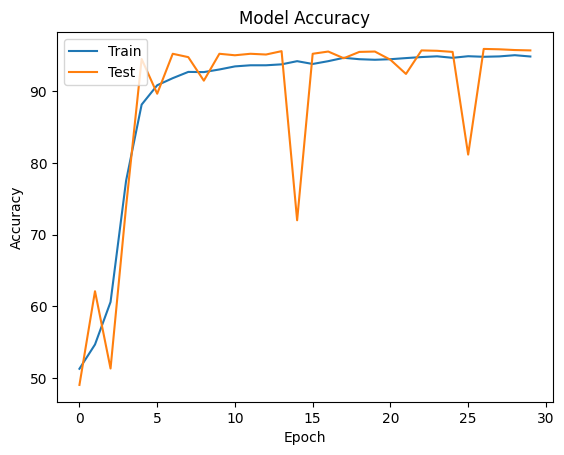

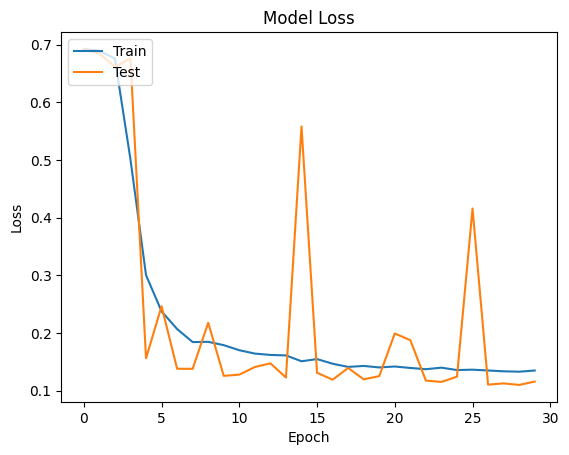

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------1-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 206.16it/s]


| Train Loss : 0.6923441257737407 |  Val Loss : 0.6907254357253556 | Train Acc : 51.15159606933594 | Val Acc : 59.86465835571289 |


100%|██████████| 241/241 [00:01<00:00, 204.51it/s]


| Train Loss : 0.6881024087801644 |  Val Loss : 0.6848739256528689 | Train Acc : 57.16330337524414 | Val Acc : 60.90577697753906 |


100%|██████████| 241/241 [00:01<00:00, 207.66it/s]


| Train Loss : 0.6505740238228788 |  Val Loss : 0.9974630239038093 | Train Acc : 64.33311462402344 | Val Acc : 51.79594039916992 |


100%|██████████| 241/241 [00:01<00:00, 207.35it/s]


| Train Loss : 0.46810106705091337 |  Val Loss : 0.3358533633586828 | Train Acc : 79.64866638183594 | Val Acc : 87.03800201416016 |


100%|██████████| 241/241 [00:01<00:00, 208.78it/s]


| Train Loss : 0.28312361056861274 |  Val Loss : 0.23974191511650064 | Train Acc : 89.22576141357422 | Val Acc : 90.26548767089844 |


100%|██████████| 241/241 [00:01<00:00, 208.70it/s]


| Train Loss : 0.2216389398975813 |  Val Loss : 0.19506609542242007 | Train Acc : 91.62004089355469 | Val Acc : 91.98334503173828 |


100%|██████████| 241/241 [00:01<00:00, 187.09it/s]


| Train Loss : 0.19311400750432606 |  Val Loss : 0.6049305393938935 | Train Acc : 92.67404174804688 | Val Acc : 74.85684967041016 |


100%|██████████| 241/241 [00:01<00:00, 157.53it/s]


| Train Loss : 0.18432011421704417 |  Val Loss : 0.18547952963637537 | Train Acc : 93.07743072509766 | Val Acc : 92.66007232666016 |


100%|██████████| 241/241 [00:01<00:00, 154.23it/s]


| Train Loss : 0.17116560046533796 |  Val Loss : 0.17969371018885696 | Train Acc : 93.23357391357422 | Val Acc : 92.81624603271484 |


100%|██████████| 241/241 [00:01<00:00, 206.72it/s]


| Train Loss : 0.16880615194586865 |  Val Loss : 0.2560108398658915 | Train Acc : 93.32466125488281 | Val Acc : 90.26548767089844 |


100%|██████████| 241/241 [00:01<00:00, 208.33it/s]


| Train Loss : 0.16278667263244323 |  Val Loss : 0.1651918242333039 | Train Acc : 93.70201873779297 | Val Acc : 93.28475189208984 |


100%|██████████| 241/241 [00:01<00:00, 200.32it/s]


| Train Loss : 0.1519865756946517 |  Val Loss : 0.16998839580626282 | Train Acc : 94.10540008544922 | Val Acc : 93.44091796875 |


100%|██████████| 241/241 [00:01<00:00, 208.98it/s]


| Train Loss : 0.15038996123616077 |  Val Loss : 0.3031065307173612 | Train Acc : 94.2875747680664 | Val Acc : 85.52837371826172 |


100%|██████████| 241/241 [00:01<00:00, 143.16it/s]


| Train Loss : 0.14795430277849297 |  Val Loss : 0.19597670375885815 | Train Acc : 94.57384490966797 | Val Acc : 92.19157409667969 |


100%|██████████| 241/241 [00:01<00:00, 205.00it/s]


| Train Loss : 0.1405715940167816 |  Val Loss : 0.18941000726060406 | Train Acc : 94.92517852783203 | Val Acc : 93.59709167480469 |


100%|██████████| 241/241 [00:01<00:00, 167.73it/s]


| Train Loss : 0.1458289854336959 |  Val Loss : 0.14897905755642643 | Train Acc : 94.2094955444336 | Val Acc : 94.1176528930664 |


100%|██████████| 241/241 [00:01<00:00, 154.57it/s]


| Train Loss : 0.1351866402376683 |  Val Loss : 0.16843252182718296 | Train Acc : 94.78204345703125 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:01<00:00, 181.83it/s]


| Train Loss : 0.13406565379479835 |  Val Loss : 0.16687835933701686 | Train Acc : 94.89915466308594 | Val Acc : 93.44091796875 |


100%|██████████| 241/241 [00:01<00:00, 206.37it/s]


| Train Loss : 0.1324140855202678 |  Val Loss : 0.17304940670360228 | Train Acc : 94.78204345703125 | Val Acc : 92.86830139160156 |


100%|██████████| 241/241 [00:01<00:00, 206.53it/s]


| Train Loss : 0.13102231295179473 |  Val Loss : 0.1866895526973361 | Train Acc : 94.96421813964844 | Val Acc : 91.25455474853516 |


100%|██████████| 241/241 [00:01<00:00, 203.54it/s]


| Train Loss : 0.13466581156745155 |  Val Loss : 0.18317828865048905 | Train Acc : 94.75601959228516 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:01<00:00, 205.77it/s]


| Train Loss : 0.1307200957853141 |  Val Loss : 0.16965716095045666 | Train Acc : 94.92517852783203 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:01<00:00, 203.73it/s]


| Train Loss : 0.12948783987414433 |  Val Loss : 0.15029793263398225 | Train Acc : 94.91216278076172 | Val Acc : 94.32587432861328 |


100%|██████████| 241/241 [00:01<00:00, 203.94it/s]


| Train Loss : 0.12782106321976414 |  Val Loss : 0.16965081785136 | Train Acc : 95.01626586914062 | Val Acc : 93.33680725097656 |


100%|██████████| 241/241 [00:01<00:00, 171.15it/s]


| Train Loss : 0.12685410543529727 |  Val Loss : 0.15325726031624887 | Train Acc : 95.17241668701172 | Val Acc : 94.01353454589844 |


100%|██████████| 241/241 [00:01<00:00, 153.21it/s]


| Train Loss : 0.1250936934059133 |  Val Loss : 0.15679142214113628 | Train Acc : 95.120361328125 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 128.20it/s]


| Train Loss : 0.12785265228154213 |  Val Loss : 0.14384440267972762 | Train Acc : 95.01626586914062 | Val Acc : 94.79438018798828 |


100%|██████████| 241/241 [00:01<00:00, 141.83it/s]


| Train Loss : 0.12389819144659718 |  Val Loss : 0.23407335719623942 | Train Acc : 95.18543243408203 | Val Acc : 88.44352722167969 |


100%|██████████| 241/241 [00:01<00:00, 202.94it/s]


| Train Loss : 0.12246280924675207 |  Val Loss : 0.1428938572903933 | Train Acc : 95.00325012207031 | Val Acc : 94.63821411132812 |


100%|██████████| 241/241 [00:01<00:00, 203.05it/s]


| Train Loss : 0.12360265049247209 |  Val Loss : 0.16067512235321824 | Train Acc : 95.06832122802734 | Val Acc : 94.22176361083984 |


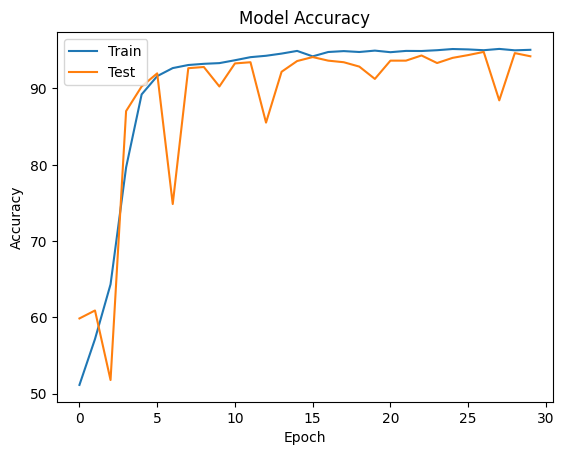

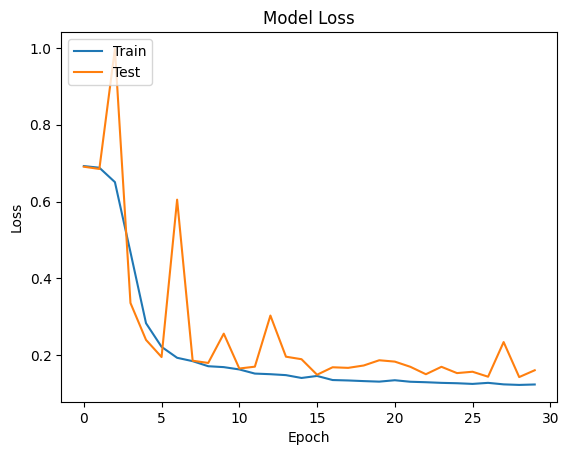

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------2-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 200.29it/s]


| Train Loss : 0.6919912854106534 |  Val Loss : 0.6910569724597265 | Train Acc : 52.59596633911133 | Val Acc : 52.00416564941406 |


100%|██████████| 241/241 [00:01<00:00, 202.69it/s]


| Train Loss : 0.6871244846106972 |  Val Loss : 0.6816031393255187 | Train Acc : 56.629798889160156 | Val Acc : 57.20978927612305 |


100%|██████████| 241/241 [00:01<00:00, 170.87it/s]


| Train Loss : 0.6419239592071315 |  Val Loss : 0.5198250368571046 | Train Acc : 65.25699615478516 | Val Acc : 72.35814666748047 |


100%|██████████| 241/241 [00:01<00:00, 155.20it/s]


| Train Loss : 0.4134117684700928 |  Val Loss : 0.28580987706338284 | Train Acc : 81.8998031616211 | Val Acc : 87.19417572021484 |


100%|██████████| 241/241 [00:01<00:00, 170.98it/s]


| Train Loss : 0.2510830735396315 |  Val Loss : 0.22279350198904718 | Train Acc : 90.21470642089844 | Val Acc : 91.82717895507812 |


100%|██████████| 241/241 [00:01<00:00, 205.91it/s]


| Train Loss : 0.22844897193825703 |  Val Loss : 0.1688953742039725 | Train Acc : 90.93038177490234 | Val Acc : 94.06559753417969 |


100%|██████████| 241/241 [00:01<00:00, 202.91it/s]


| Train Loss : 0.20499724208697842 |  Val Loss : 0.2385304291586681 | Train Acc : 91.93233489990234 | Val Acc : 91.35867309570312 |


100%|██████████| 241/241 [00:01<00:00, 206.32it/s]


| Train Loss : 0.19088390841643843 |  Val Loss : 0.1726807387432259 | Train Acc : 92.66102600097656 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:01<00:00, 207.94it/s]


| Train Loss : 0.17515695021380523 |  Val Loss : 0.4540169107364583 | Train Acc : 92.76512908935547 | Val Acc : 83.3420181274414 |


100%|██████████| 241/241 [00:01<00:00, 204.95it/s]


| Train Loss : 0.17436297891216768 |  Val Loss : 0.16432045694520112 | Train Acc : 92.92127227783203 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:01<00:00, 140.28it/s]


| Train Loss : 0.1627642997302401 |  Val Loss : 0.3807687676244574 | Train Acc : 93.57189178466797 | Val Acc : 84.85163879394531 |


100%|██████████| 241/241 [00:02<00:00, 87.98it/s] 


| Train Loss : 0.16128127211298873 |  Val Loss : 0.15627752772474468 | Train Acc : 93.63695526123047 | Val Acc : 94.32587432861328 |


100%|██████████| 241/241 [00:01<00:00, 170.56it/s]


| Train Loss : 0.1527445559430487 |  Val Loss : 0.2704996116738621 | Train Acc : 93.94924926757812 | Val Acc : 89.64081573486328 |


100%|██████████| 241/241 [00:01<00:00, 206.80it/s]


| Train Loss : 0.15389550640044775 |  Val Loss : 0.16650912892895148 | Train Acc : 93.98828887939453 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:01<00:00, 203.45it/s]


| Train Loss : 0.15205052670093813 |  Val Loss : 0.15714260279215517 | Train Acc : 93.97527313232422 | Val Acc : 93.909423828125 |


100%|██████████| 241/241 [00:01<00:00, 206.07it/s]


| Train Loss : 0.14771312205284523 |  Val Loss : 0.1849856180658119 | Train Acc : 94.1574478149414 | Val Acc : 92.66007232666016 |


100%|██████████| 241/241 [00:01<00:00, 204.83it/s]


| Train Loss : 0.14821552469788354 |  Val Loss : 0.13681334646332394 | Train Acc : 93.89720916748047 | Val Acc : 95.00260925292969 |


100%|██████████| 241/241 [00:01<00:00, 205.66it/s]


| Train Loss : 0.13840573844036347 |  Val Loss : 0.16397924948641754 | Train Acc : 94.57384490966797 | Val Acc : 93.28475189208984 |


100%|██████████| 241/241 [00:01<00:00, 207.03it/s]


| Train Loss : 0.1448213651623012 |  Val Loss : 0.17776743145266868 | Train Acc : 94.24854278564453 | Val Acc : 93.28475189208984 |


100%|██████████| 241/241 [00:01<00:00, 186.30it/s]


| Train Loss : 0.1397774684590105 |  Val Loss : 0.1358398311572195 | Train Acc : 94.39167022705078 | Val Acc : 94.89849090576172 |


100%|██████████| 241/241 [00:01<00:00, 153.50it/s]


| Train Loss : 0.13510551846640095 |  Val Loss : 0.46565328452315324 | Train Acc : 94.62589263916016 | Val Acc : 82.97761535644531 |


100%|██████████| 241/241 [00:01<00:00, 160.27it/s]


| Train Loss : 0.13745347911815559 |  Val Loss : 0.18388252028060242 | Train Acc : 94.49577331542969 | Val Acc : 92.7121353149414 |


100%|██████████| 241/241 [00:01<00:00, 203.65it/s]


| Train Loss : 0.1328220179814678 |  Val Loss : 0.13890298823731476 | Train Acc : 94.70397186279297 | Val Acc : 94.79438018798828 |


100%|██████████| 241/241 [00:01<00:00, 195.61it/s]


| Train Loss : 0.1290812157700414 |  Val Loss : 0.31252526197115127 | Train Acc : 94.84710693359375 | Val Acc : 81.5200424194336 |


100%|██████████| 241/241 [00:01<00:00, 204.01it/s]


| Train Loss : 0.13364513940096057 |  Val Loss : 0.16435438119864526 | Train Acc : 94.49577331542969 | Val Acc : 93.38886260986328 |


100%|██████████| 241/241 [00:01<00:00, 203.74it/s]


| Train Loss : 0.13211640775804792 |  Val Loss : 0.13173368540900346 | Train Acc : 95.13337707519531 | Val Acc : 95.15877532958984 |


100%|██████████| 241/241 [00:01<00:00, 202.06it/s]


| Train Loss : 0.12903969597723394 |  Val Loss : 0.18710784481514492 | Train Acc : 95.120361328125 | Val Acc : 92.2436294555664 |


100%|██████████| 241/241 [00:01<00:00, 201.65it/s]


| Train Loss : 0.12744176753480946 |  Val Loss : 0.5167183227123989 | Train Acc : 95.0943374633789 | Val Acc : 75.53358459472656 |


100%|██████████| 241/241 [00:01<00:00, 187.32it/s]


| Train Loss : 0.12722678313827993 |  Val Loss : 0.15279879895335122 | Train Acc : 95.01626586914062 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 151.40it/s]


| Train Loss : 0.1288713198884711 |  Val Loss : 0.13913470596649075 | Train Acc : 94.97722625732422 | Val Acc : 95.00260925292969 |


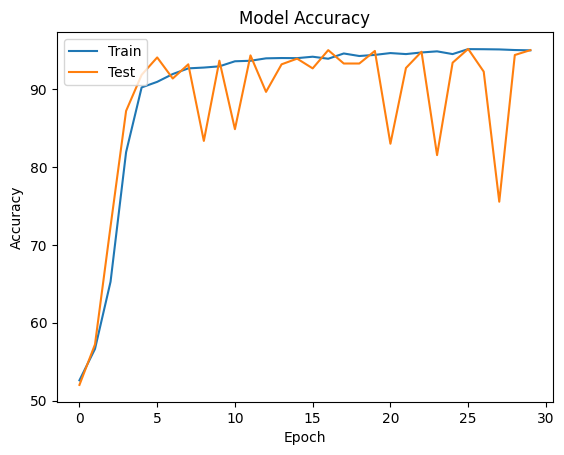

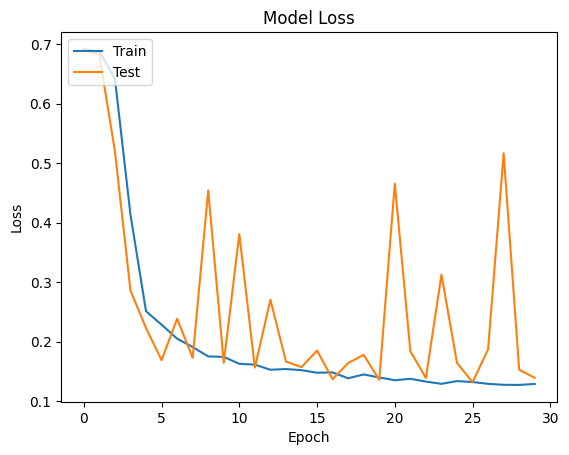

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------3-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 184.63it/s]


| Train Loss : 0.6921736427538567 |  Val Loss : 0.6900650342884689 | Train Acc : 51.75016403198242 | Val Acc : 56.84539794921875 |


100%|██████████| 241/241 [00:01<00:00, 193.36it/s]


| Train Loss : 0.6884944268302943 |  Val Loss : 0.6840206370075689 | Train Acc : 55.83604431152344 | Val Acc : 62.20718765258789 |


100%|██████████| 241/241 [00:01<00:00, 202.02it/s]


| Train Loss : 0.6699414439455751 |  Val Loss : 0.6116243202446774 | Train Acc : 61.91281509399414 | Val Acc : 70.53618621826172 |


100%|██████████| 241/241 [00:01<00:00, 198.81it/s]


| Train Loss : 0.478861307644115 |  Val Loss : 0.26035152841892667 | Train Acc : 79.25830078125 | Val Acc : 90.99427795410156 |


100%|██████████| 241/241 [00:01<00:00, 201.22it/s]


| Train Loss : 0.2907789943081726 |  Val Loss : 1.5615008131197068 | Train Acc : 88.99153900146484 | Val Acc : 53.5137939453125 |


100%|██████████| 241/241 [00:01<00:00, 200.77it/s]


| Train Loss : 0.23988942774321712 |  Val Loss : 0.17916289132470453 | Train Acc : 90.89134979248047 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:01<00:00, 201.29it/s]


| Train Loss : 0.19972875905098975 |  Val Loss : 0.2862085678768846 | Train Acc : 92.37476348876953 | Val Acc : 88.49557495117188 |


100%|██████████| 241/241 [00:01<00:00, 158.33it/s]


| Train Loss : 0.1953744978391279 |  Val Loss : 1.1959146079391567 | Train Acc : 92.11450958251953 | Val Acc : 61.84279251098633 |


100%|██████████| 241/241 [00:01<00:00, 145.92it/s]


| Train Loss : 0.18960246335358766 |  Val Loss : 0.17414178256416196 | Train Acc : 92.58295440673828 | Val Acc : 94.06559753417969 |


100%|██████████| 241/241 [00:01<00:00, 188.83it/s]


| Train Loss : 0.17090979217707375 |  Val Loss : 0.31878983479415934 | Train Acc : 93.4417724609375 | Val Acc : 88.02706909179688 |


100%|██████████| 241/241 [00:01<00:00, 199.94it/s]


| Train Loss : 0.17345678253498029 |  Val Loss : 0.15741731765554448 | Train Acc : 93.16851043701172 | Val Acc : 94.06559753417969 |


100%|██████████| 241/241 [00:02<00:00, 116.64it/s]


| Train Loss : 0.16415691679112113 |  Val Loss : 0.15868434038852913 | Train Acc : 93.29862976074219 | Val Acc : 93.85736846923828 |


100%|██████████| 241/241 [00:02<00:00, 101.39it/s]


| Train Loss : 0.15964615694577422 |  Val Loss : 0.20133252193271833 | Train Acc : 93.79310607910156 | Val Acc : 91.87923431396484 |


100%|██████████| 241/241 [00:01<00:00, 190.31it/s]


| Train Loss : 0.15306319275515842 |  Val Loss : 0.15266741338665443 | Train Acc : 93.93624114990234 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:01<00:00, 172.86it/s]


| Train Loss : 0.15328239496935475 |  Val Loss : 0.17545808195229814 | Train Acc : 94.0923843383789 | Val Acc : 94.22176361083984 |


100%|██████████| 241/241 [00:02<00:00, 82.59it/s]


| Train Loss : 0.15143004091978848 |  Val Loss : 0.23500540387218713 | Train Acc : 94.26155090332031 | Val Acc : 89.224365234375 |


100%|██████████| 241/241 [00:03<00:00, 80.33it/s]


| Train Loss : 0.14878185772413974 |  Val Loss : 0.17798644698330165 | Train Acc : 94.2225112915039 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:02<00:00, 102.58it/s]


| Train Loss : 0.14420284219395196 |  Val Loss : 0.15281428993553048 | Train Acc : 94.3396224975586 | Val Acc : 94.22176361083984 |


100%|██████████| 241/241 [00:01<00:00, 201.67it/s]


| Train Loss : 0.14077111295495295 |  Val Loss : 0.15579576847201163 | Train Acc : 94.62589263916016 | Val Acc : 94.06559753417969 |


100%|██████████| 241/241 [00:01<00:00, 168.65it/s]


| Train Loss : 0.14013864295235995 |  Val Loss : 0.21161414036126822 | Train Acc : 94.57384490966797 | Val Acc : 91.41072845458984 |


100%|██████████| 241/241 [00:01<00:00, 152.32it/s]


| Train Loss : 0.13840026405828393 |  Val Loss : 0.17153864610887615 | Train Acc : 94.53480529785156 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:01<00:00, 160.64it/s]


| Train Loss : 0.14189027265591636 |  Val Loss : 0.15138873651339263 | Train Acc : 94.36565399169922 | Val Acc : 94.1176528930664 |


100%|██████████| 241/241 [00:01<00:00, 200.52it/s]


| Train Loss : 0.13760975603372944 |  Val Loss : 0.15283278749320262 | Train Acc : 94.378662109375 | Val Acc : 94.69026947021484 |


100%|██████████| 241/241 [00:01<00:00, 203.54it/s]


| Train Loss : 0.1393286398806468 |  Val Loss : 0.14090148298644822 | Train Acc : 94.45673370361328 | Val Acc : 94.22176361083984 |


100%|██████████| 241/241 [00:01<00:00, 199.47it/s]


| Train Loss : 0.1370049106663671 |  Val Loss : 0.15133095753632722 | Train Acc : 94.63890838623047 | Val Acc : 93.909423828125 |


100%|██████████| 241/241 [00:01<00:00, 199.96it/s]


| Train Loss : 0.13957689982283286 |  Val Loss : 0.1391874942642514 | Train Acc : 94.50878143310547 | Val Acc : 94.53409576416016 |


100%|██████████| 241/241 [00:01<00:00, 200.26it/s]


| Train Loss : 0.1309676281162571 |  Val Loss : 0.13765765668728322 | Train Acc : 95.08132934570312 | Val Acc : 94.74232482910156 |


100%|██████████| 241/241 [00:01<00:00, 200.60it/s]


| Train Loss : 0.13354458495666727 |  Val Loss : 0.13986150572199582 | Train Acc : 94.65191650390625 | Val Acc : 94.63821411132812 |


100%|██████████| 241/241 [00:01<00:00, 187.15it/s]


| Train Loss : 0.1309824519058133 |  Val Loss : 0.1395023283282007 | Train Acc : 94.86011505126953 | Val Acc : 94.5861587524414 |


100%|██████████| 241/241 [00:02<00:00, 112.44it/s]


| Train Loss : 0.13060883834070988 |  Val Loss : 0.14326387622046058 | Train Acc : 95.0292739868164 | Val Acc : 94.69026947021484 |


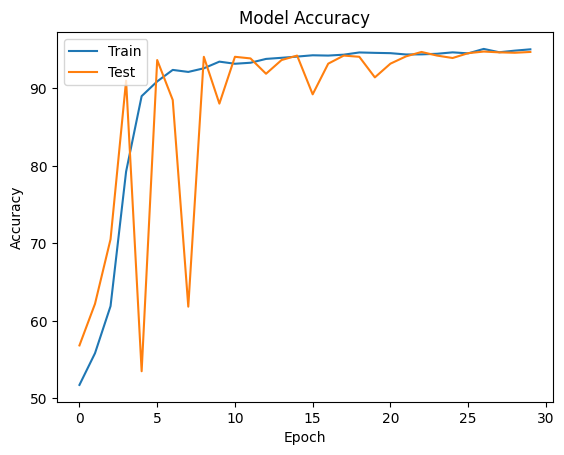

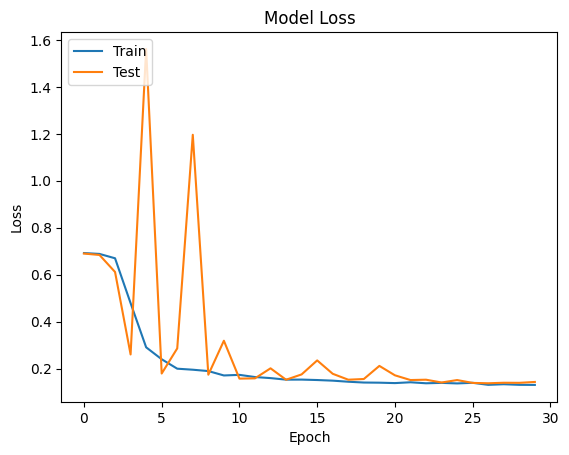

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------4-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 200.38it/s]


| Train Loss : 0.6923323351296032 |  Val Loss : 0.6918577318511736 | Train Acc : 51.776187896728516 | Val Acc : 49.557525634765625 |


100%|██████████| 241/241 [00:01<00:00, 203.76it/s]


| Train Loss : 0.687384782592895 |  Val Loss : 0.6827381192738038 | Train Acc : 57.215354919433594 | Val Acc : 61.270172119140625 |


100%|██████████| 241/241 [00:01<00:00, 202.50it/s]


| Train Loss : 0.6314175240196186 |  Val Loss : 0.2719824226502327 | Train Acc : 66.28497314453125 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:01<00:00, 199.90it/s]


| Train Loss : 0.39781975490983307 |  Val Loss : 0.25107733348364136 | Train Acc : 83.7215347290039 | Val Acc : 88.9640884399414 |


100%|██████████| 241/241 [00:01<00:00, 200.48it/s]


| Train Loss : 0.2551909050264953 |  Val Loss : 0.191357755059069 | Train Acc : 90.26675415039062 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:01<00:00, 200.83it/s]


| Train Loss : 0.2149129853709301 |  Val Loss : 0.17222926063358374 | Train Acc : 91.95835876464844 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:01<00:00, 202.83it/s]


| Train Loss : 0.2015978611382809 |  Val Loss : 0.17128930630536632 | Train Acc : 92.2836685180664 | Val Acc : 93.909423828125 |


100%|██████████| 241/241 [00:01<00:00, 151.53it/s]


| Train Loss : 0.18028212963623433 |  Val Loss : 0.1581030472655398 | Train Acc : 93.19454193115234 | Val Acc : 94.16970825195312 |


100%|██████████| 241/241 [00:01<00:00, 148.74it/s]


| Train Loss : 0.1788645865108452 |  Val Loss : 0.14928446099465595 | Train Acc : 93.32466125488281 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 201.58it/s]


| Train Loss : 0.1672786573933349 |  Val Loss : 0.17528727522070428 | Train Acc : 93.50682830810547 | Val Acc : 93.80531311035156 |


100%|██████████| 241/241 [00:01<00:00, 200.29it/s]


| Train Loss : 0.17418467214521294 |  Val Loss : 0.19358291316007586 | Train Acc : 93.42876434326172 | Val Acc : 93.02446746826172 |


100%|██████████| 241/241 [00:01<00:00, 199.43it/s]


| Train Loss : 0.15997939195117938 |  Val Loss : 0.1626324615073291 | Train Acc : 93.97527313232422 | Val Acc : 93.85736846923828 |


100%|██████████| 241/241 [00:01<00:00, 204.71it/s]


| Train Loss : 0.15594076227079218 |  Val Loss : 0.1609925198592226 | Train Acc : 93.89720916748047 | Val Acc : 93.96148681640625 |


100%|██████████| 241/241 [00:01<00:00, 202.67it/s]


| Train Loss : 0.14873453027259126 |  Val Loss : 0.16701993976614474 | Train Acc : 94.10540008544922 | Val Acc : 93.80531311035156 |


100%|██████████| 241/241 [00:01<00:00, 201.84it/s]


| Train Loss : 0.14809779373707133 |  Val Loss : 0.13924259371630837 | Train Acc : 94.4046859741211 | Val Acc : 94.48204803466797 |


100%|██████████| 241/241 [00:01<00:00, 204.86it/s]


| Train Loss : 0.1458112020925337 |  Val Loss : 0.22780636611699046 | Train Acc : 94.56082916259766 | Val Acc : 89.48464965820312 |


100%|██████████| 241/241 [00:01<00:00, 149.98it/s]


| Train Loss : 0.14298308930597914 |  Val Loss : 0.1414373371825747 | Train Acc : 94.56082916259766 | Val Acc : 94.95055389404297 |


100%|██████████| 241/241 [00:01<00:00, 144.48it/s]


| Train Loss : 0.14154573477945237 |  Val Loss : 0.14128458222693327 | Train Acc : 94.4827651977539 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 201.29it/s]


| Train Loss : 0.13285896880897555 |  Val Loss : 0.14287005863086996 | Train Acc : 95.08132934570312 | Val Acc : 94.53409576416016 |


100%|██████████| 241/241 [00:01<00:00, 200.26it/s]


| Train Loss : 0.1348899644224498 |  Val Loss : 0.13412371236272932 | Train Acc : 95.00325012207031 | Val Acc : 94.79438018798828 |


100%|██████████| 241/241 [00:01<00:00, 201.46it/s]


| Train Loss : 0.137445791452522 |  Val Loss : 0.18274888598647615 | Train Acc : 94.89915466308594 | Val Acc : 93.07653045654297 |


100%|██████████| 241/241 [00:01<00:00, 203.91it/s]


| Train Loss : 0.13736022468825965 |  Val Loss : 0.14824733540732346 | Train Acc : 94.86011505126953 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 204.73it/s]


| Train Loss : 0.13328524505308717 |  Val Loss : 0.19622567406177271 | Train Acc : 94.86011505126953 | Val Acc : 91.77511596679688 |


100%|██████████| 241/241 [00:01<00:00, 198.47it/s]


| Train Loss : 0.13335446353054078 |  Val Loss : 0.14630472504149372 | Train Acc : 94.95121002197266 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 197.85it/s]


| Train Loss : 0.12924215572564418 |  Val Loss : 0.16406852612332506 | Train Acc : 95.0943374633789 | Val Acc : 93.54502868652344 |


100%|██████████| 241/241 [00:01<00:00, 154.68it/s]


| Train Loss : 0.13111825575809696 |  Val Loss : 0.14300167262418423 | Train Acc : 94.92517852783203 | Val Acc : 94.42998504638672 |


100%|██████████| 241/241 [00:01<00:00, 149.98it/s]


| Train Loss : 0.12996177904019418 |  Val Loss : 0.14118112498804158 | Train Acc : 95.06832122802734 | Val Acc : 94.48204803466797 |


100%|██████████| 241/241 [00:01<00:00, 198.15it/s]


| Train Loss : 0.12923462414991646 |  Val Loss : 0.192099355382264 | Train Acc : 94.96421813964844 | Val Acc : 92.972412109375 |


100%|██████████| 241/241 [00:01<00:00, 200.68it/s]


| Train Loss : 0.12560607335186655 |  Val Loss : 0.14177124765432522 | Train Acc : 95.23747253417969 | Val Acc : 94.63821411132812 |


100%|██████████| 241/241 [00:01<00:00, 198.39it/s]


| Train Loss : 0.12337374921516069 |  Val Loss : 0.13142205494514655 | Train Acc : 95.3155517578125 | Val Acc : 94.69026947021484 |


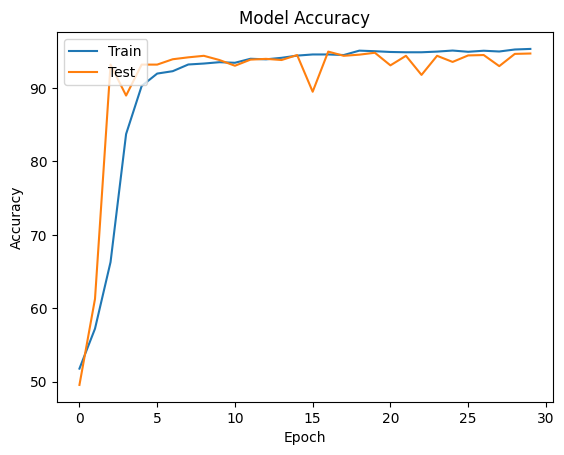

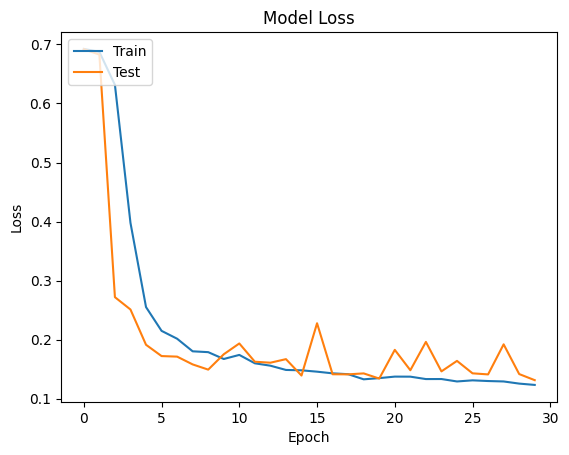

In [170]:
# sfk = StratifiedKFold(n_splits = config.FOLDS)
kfold = KFold(n_splits = config.FOLDS)
model_state_dicts = {}

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = train_sampler, collate_fn = MyCollate(0, config.MAX_LEN))
    val_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = val_sampler, collate_fn = MyCollate(0, config.MAX_LEN))

    VOCAB_SIZE = len(dataset.source_vocab)
    HIDDEN_DIM = 128
    OUTPUT_DIM = 1
    VOCAB = list(dataset.source_vocab.stoi)

    embedding_layer = get_emb_layer_with_weights(target_vocab = VOCAB, emb_model = fasttext_model, trainable = False)

    model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
    model = model.to(config.DEVICE)

#     model
#     model = Model(2, len(dataset.source_vocab), 128, 100, 1 ).to(config.DEVICE)
#     hidden = model.init_hidden(config.BATCH_SIZE)
#     model.hidden = hidden

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"-----------------------------------------------------------{fold}-fold of the model-----------------------------------------------------------")
    for epoch in range(config.EPOCHS):
        train_loss, train_correct = train_epochs(train_loader, model, loss_fn, optimizer)
        val_loss, val_correct = val_epochs(val_loader, model, loss_fn)

        train_loss = train_loss/len(train_loader.sampler)
        val_loss = val_loss/len(val_loader.sampler)
        train_acc = (train_correct/len(train_loader.sampler))*100
        val_acc = (val_correct/len(val_loader.sampler))*100

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc.cpu().numpy().tolist())
        val_accs.append(val_acc.cpu().numpy().tolist())

        print(f"| Train Loss : {train_loss} |", end = " ")
        print(f" Val Loss : {val_loss} |", end = " ")
        print(f"Train Acc : {train_acc} |", end = " ")
        print(f"Val Acc : {val_acc} |")


    # Saving the state dicts for the model
    model_state_dicts.update({f"LSTM-Model-for-{fold}" : model.state_dict(),
                             f"Model-Optimizer-for-{fold}" : optimizer.state_dict()})

    # summarize history for accuracy
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [171]:
torch.save(model_state_dicts, "/content/drive/MyDrive/Major_project/My-Model.pt")

In [172]:
def numericalize(text):

    numerialized_source = []
    numerialized_source = [dataset.source_vocab.stoi["<SOS>"]]
    numerialized_source += dataset.source_vocab.numericalize(text)
    numerialized_source.append(dataset.source_vocab.stoi["<EOS>"])

    return numerialized_source

def padding(source):
    padded_sequence = torch.zeros(config.MAX_LEN, 1, dtype = torch.int)
    source = torch.tensor(source)

    if len(source) > config.MAX_LEN:
        padded_sequence[:, 0] = source[: config.MAX_LEN]
    else:
        padded_sequence[:len(source), 0] = padded_sequence[:len(source), 0] + source

    return padded_sequence


In [173]:
def infer_processing(text):

    text = preprocessing(text)
    text = numericalize(text)
    text = padding(text)
    return text

In [174]:
aspects = ["phone", "camera", "battery", "neutral", "processor"]

def get_similarity(text, aspect):
    try:
#         text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0

def best_aspect(text, aspects):
    a = []

    for aspect in aspects:
        a.append(get_similarity(text, aspect))

    return aspects[np.argmax(a)]

In [175]:
sample = "I am really impressed with the phone's great battery backup."

ba = best_aspect(preprocessing(sample), aspects)

a = infer_processing(sample).to(config.DEVICE)

In [176]:
model.eval()
sentiment = model(a)
sentiment = sentiment.cpu().detach().numpy()[0]

if sentiment > 0.5:
    sentiment = 'Positively'
else :
    sentiment = 'Negatively'


In [177]:
print(f"The reviewer is talking {sentiment} about the {ba} of the phone in his/her comment")

The reviewer is talking Positively about the battery of the phone in his/her comment
